<a href="https://colab.research.google.com/github/iyed-01/Fake-News-Detection/blob/main/RNN_model_fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [24]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [25]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
data = pd.read_csv('/content/gdrive/My Drive/fake_news_detection/news.csv')

Combining the title with the text, it is much easier to process this way.

In [27]:
data["text_title"] = data["title"] + data["text"]

In [28]:
data.drop(['Unnamed: 0','text','title'],axis = 1,inplace = True)

0 for fake news, and 1 for real news

In [29]:
data.label.replace('FAKE',0,inplace=True)
data.label.replace('REAL',1,inplace=True)

In [30]:
data.head()

,label,text_title
0,0,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,1,Kerry to go to Paris in gesture of sympathyU.S...
3,0,Bernie supporters on Twitter erupt in anger ag...
4,1,The Battle of New York: Why This Primary Matte...


In [31]:
X = data['text_title']
y = data.label


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [33]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [34]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [35]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [36]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [37]:
y_train

1142    1
2654    0
5395    0
1170    0
4371    0
       ..
3772    1
5191    0
5226    0
5390    1
860     0
Name: label, Length: 5068, dtype: int64

model1

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
________________________________________________

We are going to use early stop, which stops when the validation loss no longer improve.

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
153/153 [==============================] - 7s 48ms/step - loss: 0.6896 - accuracy: 0.5010 - val_loss: 0.6798 - val_accuracy: 0.4951
Epoch 2/10
153/153 [==============================] - 6s 41ms/step - loss: 0.5908 - accuracy: 0.6354 - val_loss: 0.6193 - val_accuracy: 0.6746
Epoch 3/10
153/153 [==============================] - 6s 41ms/step - loss: 0.4298 - accuracy: 0.8255 - val_loss: 0.4067 - val_accuracy: 0.8205
Epoch 4/10
153/153 [==============================] - 6s 41ms/step - loss: 0.3348 - accuracy: 0.8744 - val_loss: 0.4152 - val_accuracy: 0.8107
Epoch 5/10
153/153 [==============================] - 6s 41ms/step - loss: 0.2786 - accuracy: 0.8974 - val_loss: 0.4195 - val_accuracy: 0.8166


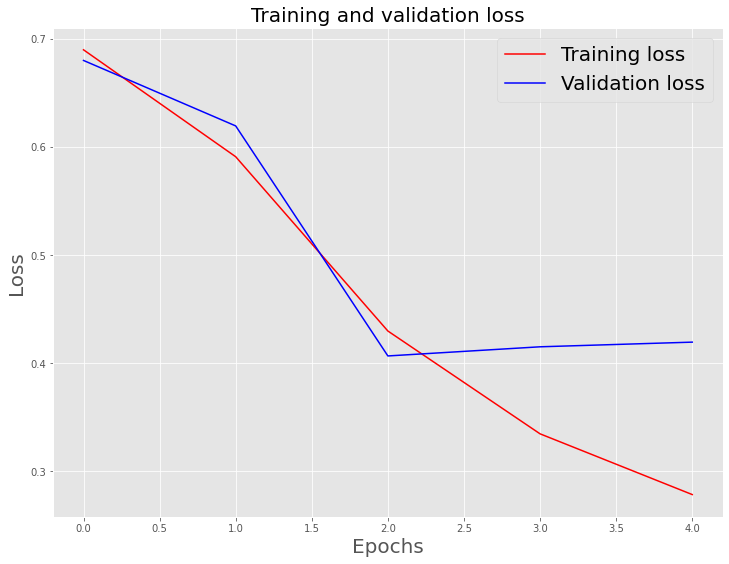

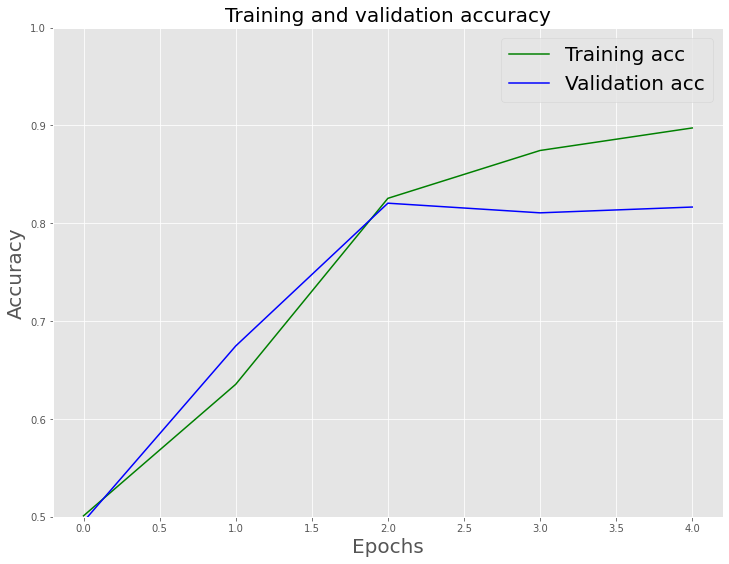

In [40]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [41]:
model.evaluate(X_test, y_test)

40/40 [==============================] - 1s 18ms/step - loss: 0.4016 - accuracy: 0.8295


[0.4016246497631073, 0.8295185565948486]

In [42]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [43]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.829518547750592
Precision on testing set: 0.7793427230046949
Recall on testing set: 0.8691099476439791


Confusion matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

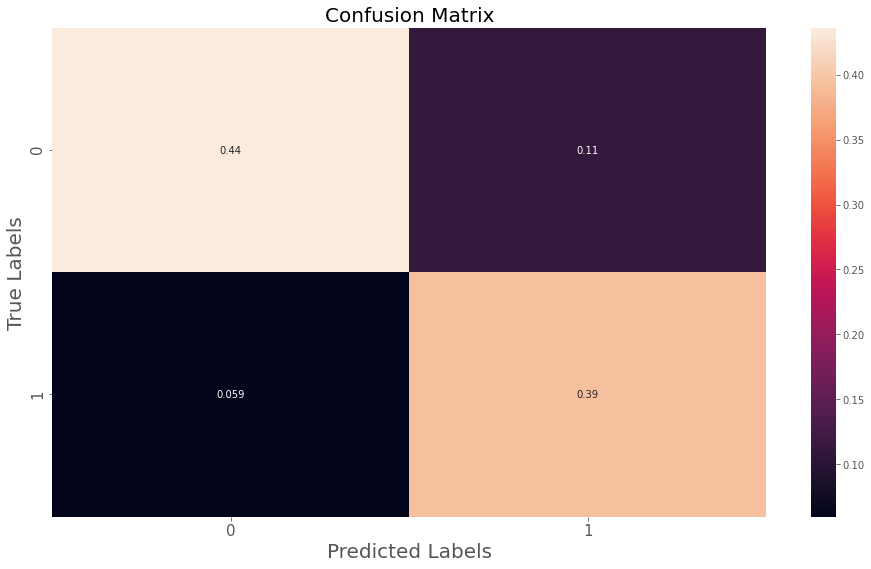

In [44]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [45]:
model_save = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_save)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
